Visualising spherical harmonics.

Example adapted from [https://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/](https://scipython.com/book/chapter-8-scipy/examples/visualizing-the-spherical-harmonics/).

## Required dependencies

We load the usual dependencies `numpy` and `scipy`, and import the `sph_harm` function from `scipy`'s _special functions_ to calculate spherical harmonics of any degree and order.

In [1]:
import numpy as np
import scipy as sp
from scipy.special import sph_harm

## Spherical grid

We'll evaluate the function on a grid of $(\theta, \phi)$ values, and calculate the corresponding cartesian coordinates $(x,y,z)$ for plotting.

In [2]:
R = 10. # arbitrary radius
Np = 36 # number of steps along phi
Nt = 18 # number of steps along theta

theta = -np.arccos(np.linspace(-1, 1, Nt)) # uniform steps along cos(theta)
phi = np.linspace(0, 2*np.pi, Np)

theta, phi = np.meshgrid(theta, phi)

x = R * np.sin(theta) * np.cos(phi) 
y = R * np.sin(theta) * np.sin(phi) 
z = R * np.cos(theta) 

## Spherical harmonics

Note that `sph_harm` harmfully takes the opposite convention to ours with regards to the meaning of `theta` and `phi` in the help page.

In [3]:
l = 5
m = 3

Ylm = 1/R**(l+1) * sph_harm(m, l, phi, theta).real

## Plotting (static)

We first use `matplotlib` to create a 3D surface plot, rescaling the scalar values to a colour palette defined to map on the interval $[0,1]$.

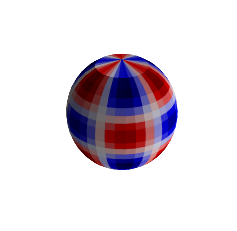

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

fmax, fmin = Ylm.max(), Ylm.min()
Ylm = (Ylm - fmin)/(fmax - fmin)

# Set the aspect ratio to 1 so our sphere looks spherical
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.seismic(Ylm))
# Turn off the axis planes
ax.set_axis_off()
plt.show()

## Plotting (interactive)

With the Jupyter notebook, or in the ipython console, you can create an interactive version of this plot using the Plotly library.

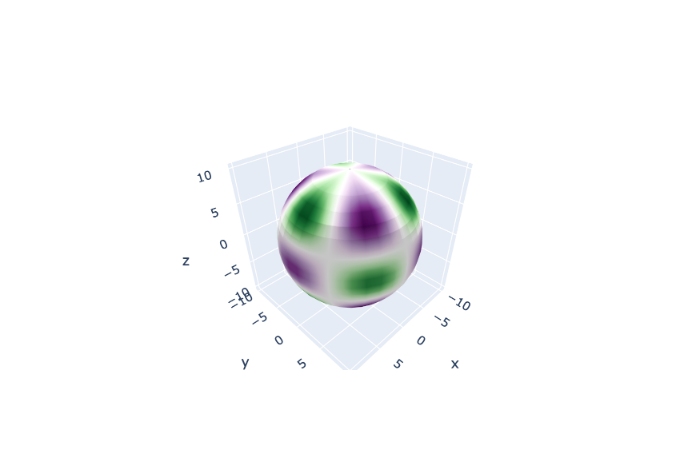

In [5]:
import plotly.graph_objects as go
#import chart_studio.plotly as py

fig = go.Figure()

fig.add_trace(go.Surface(x=x, y=y, z=z, 
                surfacecolor=Ylm, 
                showscale=False, 
                colorscale='PrGN'))

# fig.show() # note: interactive output doesn't work on this website, but run it in Jupyter or Spyder

fig.show(renderer='png')

## Gradient of spherical harmonics – vector field

From a 3D array representing the scalar potential we can evaluate a numerical gradient in spherical coordinates, which could represent for example the geomagnetic field.

In [6]:
l = 5
m = 3

R = 10.
Np = 36
Nt = 36
Nr=10
rhalf=Nr//2 -1

r = np.linspace(0.99*R, 1.01*R, Nr)
theta = np.linspace(0, np.pi, Nt)
phi = np.linspace(0, 2*np.pi, Np)

d_r = r[1]-r[0] 
d_theta = theta[1]-theta[0] 
d_phi = phi[1]-phi[0]

theta, phi, r = np.meshgrid(theta, phi, r)


Ylm = 1/r**(l+1) * sph_harm(m, l, phi, theta).real

In [7]:


# prefactors
oneoverr = 1/r
oneoverrsintheta = 1/(r*np.sin(theta)+1e-12)

costheta = np.cos(theta)[:,:,rhalf]
sintheta = np.sin(theta)[:,:,rhalf]
cosphi = np.cos(phi)[:,:,rhalf]
sinphi = np.sin(phi)[:,:,rhalf]

xx = R*sintheta*cosphi 
yy = R*sintheta*sinphi 
zz = R*costheta 


def field_gradient(Y):
    deriv = np.gradient(Y)
    ## from partial derivatives to spherical gradient
    dVt = deriv[1]
    dVp = deriv[0] 
    dVr = deriv[2]
    
    Br = -dVr[:,:,rhalf] * 1/d_r
    Bt = -oneoverr[:,:,rhalf] * dVt[:,:,rhalf] * 1/d_theta
    Bp = -oneoverrsintheta[:,:,rhalf] * dVp[:,:,rhalf] * 1/d_phi


    Bx = sintheta*cosphi*Br + costheta*cosphi*Bt - sinphi*Bp
    By = sintheta*sinphi*Br + costheta*sinphi*Bt + cosphi*Bp
    Bz = costheta*Br - sintheta*Bt

    u=np.where(np.isfinite(Bx), Bx, 0)
    v=np.where(np.isfinite(By), By, 0)
    w=np.where(np.isfinite(Bz), Bz, 0)
    B2 = u**2 + v**2 + w**2
    maxB = np.sqrt(np.max(B2))
    return(u/maxB, v/maxB, w/maxB)

u, v, w = field_gradient(Ylm)


## Plotting

We use `plotly` to produce an interactive 3D surface plot, and add arrows to represent the vector field at a given radial distance.

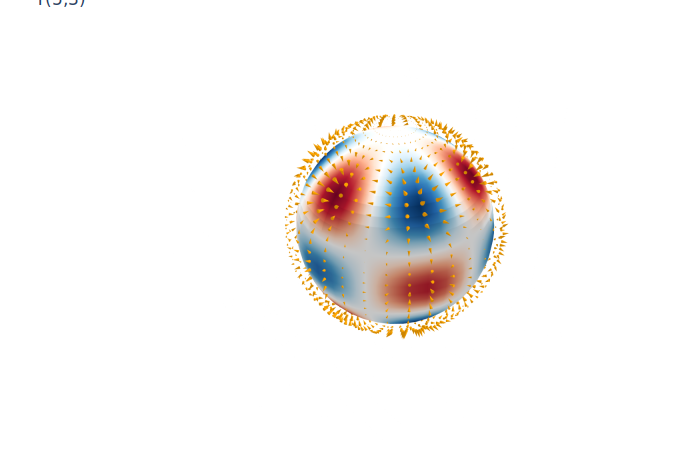

In [8]:

import plotly.graph_objects as go
import plotly.io as pio 

Rout = 1.1 
sizeref = 0.8
step = 1

fig = go.Figure()

fig.add_trace(go.Surface(x=xx, y=yy, z=zz, 
                surfacecolor=Ylm[:,:,rhalf], 
                showscale=False,  
                colorscale='RdBu'))

fig.add_trace(go.Cone(
  x=Rout*np.concatenate(xx[::step, ::step]),
  y=Rout*np.concatenate(yy[::step, ::step]),
  z=Rout*np.concatenate(zz[::step, ::step]),
  u=np.concatenate(u[::step, ::step]),
  v=np.concatenate(v[::step, ::step]),
  w=np.concatenate(w[::step, ::step]),
  showlegend=False,
  showscale=False,
  colorscale=[(0, "orange"), (0.5, "orange"), (1, "orange")],
  sizemode="absolute",
  sizeref=sizeref))

fig.update_layout(title_text="Y({0},{1})".format(l,m),showlegend=False)

# set annotations white for clarity
fig.update_layout(scene = dict(
                    xaxis = dict(
                        nticks=0,
                        color='white',
                         backgroundcolor="white",
                         gridcolor="white",
                         showbackground=False,
                         zerolinecolor="white",),
                    yaxis = dict(
                        color='white',
                        backgroundcolor="white",
                        gridcolor="white",
                        showbackground=False,
                        zerolinecolor="white"),
                    zaxis = dict(
                        color='white',
                        backgroundcolor="white",
                        gridcolor="white",
                        showbackground=False,
                        zerolinecolor="white",),),
                    width=1200,
                    margin=dict(
                    r=10, l=100,
                    b=10, t=10)
                  )
# fig.show() # use this in interactive notebook
fig.show(renderer='svg')


_Download this page [as a Jupyter notebook](https://github.com/vuw-scps/python-physics/raw/master/notebooks/phys304/Ylm.ipynb) or as a [standalone Python script](https://github.com/vuw-scps/python-physics/raw/master/scripts/phys304/Ylm.py)._